In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm as tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
# import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
from codeStore import support_fun_baseflow as spf_bf
# %matplotlib notebook

from sympy.parsing import mathematica
import sympy
from sympy.printing.latex import LatexPrinter, print_latex
from sympy.utilities.lambdify import lambdify, lambdastr
import inspect

%matplotlib inline
PWD = os.getcwd()
params = {'animation.html':      'html5',
          'font.family':         'sans-serif', 
          'font.size':           30, 
          'text.latex.preamble': [r'\usepackage{bm}',
                                  r'\usepackage{amsmath}',
                                  r'\usepackage{amssymb}',
                                  r'\usepackage{mathrsfs}',
                                  r'\DeclareMathOperator{\Tr}{Tr}', ], 
          'text.usetex':         True}
plt.rcParams.update(params)
np.set_printoptions(linewidth=110, precision=5)


In [95]:
load_pickle = '/home/zhangji/stokes_flow_master/src/ecoC01B05_baseFlow.pickle'
save_pickle = '/home/zhangji/stokes_flow_master/src/ecoC01B05_baseFlow_mdf.pickle'
fct = 1

with open(load_pickle, 'rb') as handle:
    tpick = pickle.load(handle)

uw_Base_list = tpick['uw_Base_list']
print(uw_Base_list[9])
print()

uw_Base_list2 = uw_Base_list.copy()
uw_Base_list2[9][3] = uw_Base_list[9][3] * fct
uw_Base_list2[9][4] = uw_Base_list[9][4] * fct
print(uw_Base_list2[9])

tpick['uw_Base_list'] = uw_Base_list2
with open(save_pickle, 'wb') as handle:
    pickle.dump(tpick, handle, protocol=4)
print('save to %s' % save_pickle)

[   0.00064   -0.00220    0.00402   -0.00132   -0.00124   -0.75710]

[   0.00064   -0.00220    0.00402   -0.00132   -0.00124   -0.75710]
save to /home/zhangji/stokes_flow_master/src/ecoC01B05_baseFlow_mdf.pickle


In [101]:
tpick['problem_kwargs']

{'MPISIZE': 24,
 'Tfct': 1,
 'basei': 1,
 'belemshandle': 'belems',
 'bnodeshandle': 'bnodes',
 'center': array([0, 0, 0]),
 'ch': 3.0,
 'dist_hs': 0.5,
 'ds': 0.023333,
 'eT': -1.0,
 'eh': -1.0,
 'es': -1.0,
 'ffweightT': 2.0,
 'ffweightx': 2.0,
 'ffweighty': 2.0,
 'ffweightz': 2.0,
 'field_range': array([[-3, -3, -3],
        [ 3,  3,  3]]),
 'fileHandle': 'ecoC01B05_baseFlow',
 'getConvergenceHistory': False,
 'hfct': 1.0,
 'int_epsabs': 1e-200,
 'int_epsrel': 1e-10,
 'int_limit': 1000,
 'left_hand': False,
 'ls': 1.0,
 'matname': 'body1',
 'matrix_method': 'pf',
 'n_grid': array([10, 10, 10]),
 'n_node_threshold': 5000,
 'n_tail': 1,
 'ntT': 20,
 'nth': 20,
 'ph': 0.666667,
 'pickProblem': False,
 'plot_geo': False,
 'precondition_method': 'none',
 'rT1': 0.2,
 'rT2': 0.03,
 'region_type': 'rectangle',
 'rel_Uh': array([   0.00000,    0.00000,    0.00000,    0.00000,    0.00000,    0.00000]),
 'rel_Us': array([   0.00000,    0.00000,    0.00000,    0.00000,    0.00000,    0.00000])

In [98]:
t0 = time()
t_theta, t_phi, t_psi = 0.01 * np.pi, 0.7 * np.pi, 0.7 * np.pi 
max_t = 100
update_fun = '5bs'
rtol = 1e-6
atol = 1e-9
eval_dt = 0.01
save_every = 1
omega_tail = 1
flow_strength = 0
table_name2 = 'ecoC01B05_baseFlow'
# table_name2 = 'ecoC01B05_baseFlow_mdf'

# base flow method, vsesion 4
t0 = time()
kwargs = {'planeShearRate': np.array((1, 0, 0)) * flow_strength, }
ini_center = np.zeros(3)
problemHandle=jm.ShearJefferyProblem
d3 = spf_bf.do_GivenFlowObj(t_theta, t_phi, t_psi, max_t, table_name=table_name2, 
                            update_fun=update_fun, rtol=rtol, atol=atol, eval_dt=eval_dt, 
                            save_every=save_every, tqdm_fun=tqdm_notebook, return_psi_body=False,
                            omega_tail=omega_tail, ini_center=ini_center, 
                            problemHandle=problemHandle, **kwargs)
base_t, base_dt, base_X, base_thphps, base_U, base_W, base_psi_t = d3
t1 = time()
print('init \\theta=%.3f, \\phi=%.3f, \\psi=%.3f, ' % (t_theta, t_phi, t_psi))
print('last \\theta=%.3f, \\phi=%.3f, \\psi=%.3f, ' % (base_thphps[-1, 0], base_thphps[-1, 0], base_thphps[-1, 0]))
print('%s: run %d loops/times using %fs' % ('do_ShearFlowPetsc4nPsiObj', max_t, (t1 - t0)))
print('%s_%s rt%.0e, at%.0e, dt%.0e %.1fs' % ('PETSC RK', update_fun, rtol, atol, eval_dt, (t1 - t0)))
# spf_tb.show_table_result_v2(Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, 
#                             Table_phi, Table_psi, Table_eta, save_every=save_every)
# spf_tb.light_show_theta_phi(Table_t, Table_dt, Table_X, Table_P, Table_P2, 
#                             Table_theta, Table_phi, Table_psi, Table_eta)


init \theta=0.031, \phi=2.199, \psi=2.199, 
last \theta=0.037, \phi=0.037, \psi=0.037, 
do_ShearFlowPetsc4nPsiObj: run 100 loops/times using 0.303404s
PETSC RK_5bs rt1e-06, at1e-09, dt1e-02 0.3s


[   0.00064   -0.00220    0.00402   -0.00132   -0.00124   -0.75710]


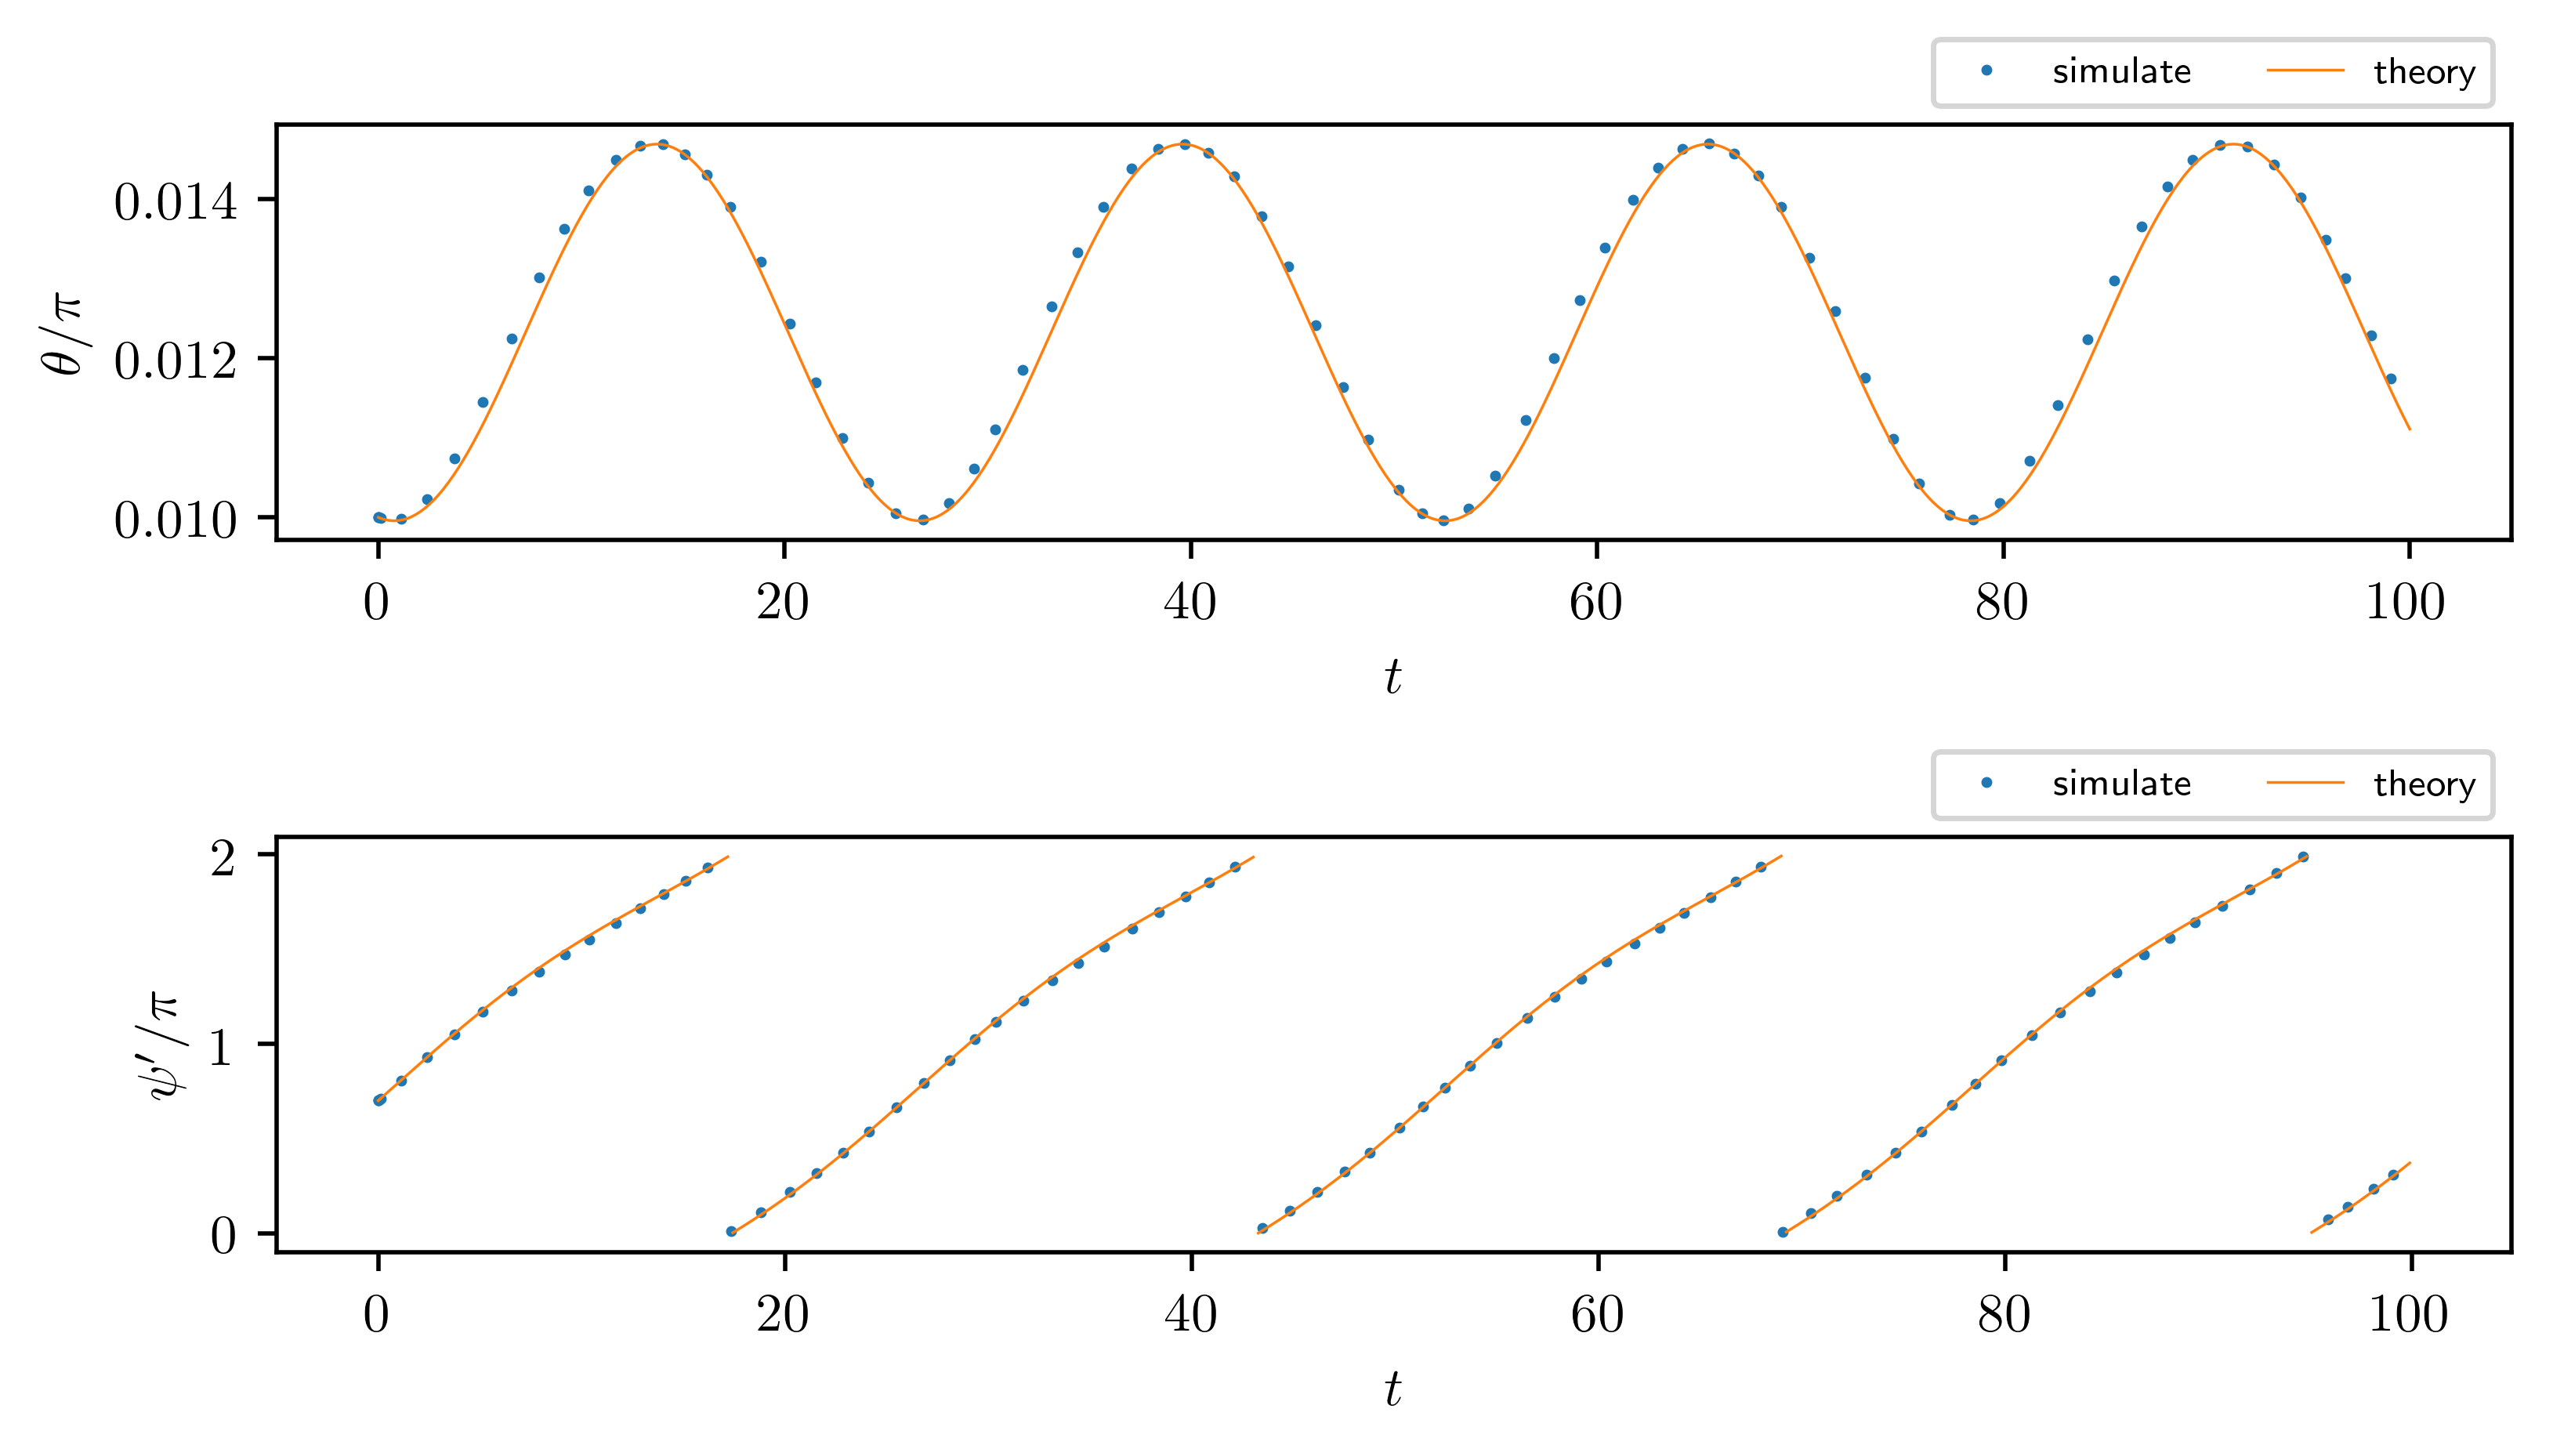

In [99]:
figsize, dpi = np.array((16, 9)) * 0.4, 500 
ms, linewidth = 2, 0.5
t_plt_min = 0

fun_th = lambda th0, ps0, wx, wy, wz, z: (th0 + th0*wz + wx*np.cos(ps0) - wx*np.cos(ps0 + z + wz*z) - wy*np.sin(ps0) + wy*np.sin(ps0 + z + wz*z))/(1 + wz)
fun_ps = lambda th0, ps0, wx, wy, wz, z: (ps0 + z + wz*z + (2*1 / np.tan(th0)*np.sin(((1 + wz)*z)/2.)*(wx*np.cos(ps0 + ((1 + wz)*z)/2.) - wy*np.sin(ps0 + ((1 + wz)*z)/2.)))/(1 + wz)) % (2 * np.pi)
# fun_ps = lambda th0, ps0, wx, wy, wz, z: (ps0 + z + wz*z) % (2 * np.pi)

load_pickle = '/home/zhangji/stokes_flow_master/src/%s.pickle' % table_name2
with open(load_pickle, 'rb') as handle:
    tpick = pickle.load(handle)
wx, wy, wz = tpick['uw_Base_list'][9][3:6] * (1, 1, 1)
print(tpick['uw_Base_list'][9])

homo_t = np.linspace(0, max_t, base_t.size*10)
homo_th = fun_th(t_theta, t_psi, wx, wy, wz, homo_t)
homo_ps = fun_ps(t_theta, t_psi, wx, wy, wz, homo_t)

base_idx = base_t >= t_plt_min
homo_idx = homo_t >= t_plt_min
fig, axs = plt.subplots(2, 1, figsize=figsize, dpi=dpi, constrained_layout=True)
axi = axs[0]
axi.plot(base_t[base_idx], base_thphps[:, 0][base_idx] / np.pi, '.', label='simulate', ms=ms)
axi.plot(homo_t[homo_idx], homo_th[homo_idx] / np.pi, '-C1', label='theory', linewidth=linewidth)
axi.set_xlabel('$t$')
axi.set_ylabel('$\\theta / \\pi$')
axi.legend(ncol=2, loc='lower right', bbox_to_anchor=(1, 1), fontsize='x-small')
axi = axs[1]
axi.plot(base_t[base_idx], base_psi_t[base_idx] / np.pi, '.', label='simulate', ms=ms)
axi.plot(homo_t[homo_idx][:2], homo_ps[homo_idx][:2] / np.pi, '-C1', label='theory', linewidth=linewidth)
axi.set_xlabel('$t$')
axi.set_ylabel("$\\psi' / \\pi$")
axi.legend(ncol=2, loc='lower right', bbox_to_anchor=(1, 1), fontsize='x-small')
for i0, i1 in spf_tb.separate_angle_idx(homo_ps[homo_idx]):
    axi.plot(homo_t[homo_idx][i0:i1], homo_ps[homo_idx][i0:i1] / np.pi, '-C1', linewidth=linewidth)


In [53]:
1 / np.tan(0.0001)

9999.999966666666